
# Mapping Groundwater Contaminants of California

Potential goals of this notebook:
1. Clean the dataset into a workable dataframe
2. Spatially plot the data using geopandas, or cartopy
3. ...

## 1. Reorganizing the data

This first section will deal with cleaning and reorganizing the data. 

(The `%matplotlib inline` syntax prints out the figures that are created after each specific call.)

In [66]:
%matplotlib inline
from matplotlib import pyplot as plt

## Imports
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_columns', 500)

## Set the data's directory path
script_dir = os.path.abspath('')
data_dir   = os.path.join( os.path.split(os.path.split(script_dir)[0])[0], # shared path
                           'whw2019_India GW Code & Data\\whw2019_NWQData' )

The data we are using for this analysis are from a collaboration between the United States Geological Survey ([USGS](https://www.usgs.gov/)), the Environmental Protection Agency([EPA](https://www.epa.gov/)), United States Department of Agriculture Agricultural Reaseach Service ([USDA ARS](https://www.ars.usda.gov/)), and the National Water Quality Monitoring Council ([NWQMC](https://acwi.gov/monitoring/)). The groundwater quality data was aggragated and downloaded from the [Water Quality Portal](https://www.waterqualitydata.us/coverage/). 

The reported data sources are:
* National Water Information System ([NWIS](https://waterdata.usgs.gov/nwis)) - USGS
* STOrage and RETrieval ([STORET](https://www.epa.gov/waterdata/water-quality-data-wqx)) Data Warehouse - EPA
* Sustaining The Earth's Watersheds - Agricultural Research Database System ([STEWARDS]())

For now the state/region of interest is California (CA). However, we hope to be able to apply similar analyses to other states around the US, or to other countries (e.g., India) should adequate spatial (X,Y,Z) and temporal data resolution be available.

To read in the datafiles, we must make the proper call toward their storage location (on Hydroshare). The following `pd.read_csv` commands may present with some warnings after running. In this instance, the warnings are fine to ignore (however, always be mindful of the coding issues). 


In [67]:
# Enter state code in 'state' variable to read in that states data results.
state = 'CA'
results  = pd.read_csv(r'{}\\{}_result.csv'.format(data_dir, state))
stations = pd.read_csv(r'{}\\{}_station.csv'.format(data_dir, state))

C:\Users\allan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (9,10,11,12,13,14,16,18,19,23,33,37,39,42,47,57,59,61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\allan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [68]:
results.drop(columns=['OrganizationIdentifier', 
                      'OrganizationFormalName',
                      'ActivityIdentifier', 
                      'ActivityTypeCode', 
                      'ActivityMediaName',
                      'ActivityMediaSubdivisionName',
                      'ResultStatusIdentifier', 
                      'StatisticalBaseCode', 
                      'ResultValueTypeName',
                      'ResultWeightBasisText', 
                      'ResultTimeBasisText',
                      'ResultTemperatureBasisText',
                      'ResultParticleSizeBasisText',
                      'PrecisionValue', 
                      'ResultCommentText',
                      'USGSPCode',
                      'ResultDepthHeightMeasure/MeasureValue',
                      'ResultDepthHeightMeasure/MeasureUnitCode',
                      'ResultDepthAltitudeReferencePointText', 
                      'SubjectTaxonomicName',
                      'SampleTissueAnatomyName',
                      'ResultAnalyticalMethod/MethodIdentifier',
                      'ResultAnalyticalMethod/MethodIdentifierContext',
                      'ResultAnalyticalMethod/MethodName', 
                      'MethodDescriptionText',
                      'LaboratoryName',
                      'AnalysisStartDate', 
                      'ResultLaboratoryCommentText',
                      'DetectionQuantitationLimitTypeName',
                      'DetectionQuantitationLimitMeasure/MeasureValue',
                      'DetectionQuantitationLimitMeasure/MeasureUnitCode',
                      'PreparationStartDate', 
                      'ProviderName',
                      'ProjectIdentifier',
                      'ActivityConductingOrganizationText',
                      'ActivityCommentText',
                      'MeasureQualifierCode', 
                      'SampleCollectionMethod/MethodIdentifier',
                      'SampleCollectionMethod/MethodIdentifierContext',
                      'SampleCollectionMethod/MethodName',
                      'SampleCollectionEquipmentName',
                      'ResultDetectionConditionText'
                     ], inplace=True)

# # preview the data
# results.head()
# stations.head()

After uploading/reading the .csv file as a `Pands` dataframe, we dropped unnecessary column values (above). The next step is to merge the two data frames `results` and `stations` by the station identifier to obtain a unified dataframe.

We have reset the "headers" of the rows to be the 'MonitoringLocationIdentifier' for each station. The new variable `mwd` stands for "merged well dataframe".

The bounding box for Califonia was obtained [here](https://gist.github.com/jakebathman/719e8416191ba14bb6e700fc2d5fccc5).

In [69]:
# california bounding box information
ca_max_lon = -114.1315
ca_min_lon = -124.6509
ca_max_lat = 42.0126
ca_min_lat = 32.5121

# creat boolean conditional statements
lon_condition = (ca_min_lon <= stations['LongitudeMeasure']) & (stations['LongitudeMeasure'] <= ca_max_lon)
lat_condition = (ca_min_lat <= stations['LatitudeMeasure']) & (stations['LatitudeMeasure'] <= ca_max_lat)

In [70]:
# Check for removal of inaccurate points
# stations.shape

# clean the data to drop stations outside the bounding box of California
stations = stations.loc[ (lat_condition & lon_condition) ,:]

# Check for removal of inaccurate points
# stations.shape

In [71]:
mwd = stations.merge( results, on='MonitoringLocationIdentifier' )
mwd = mwd.set_index( 'MonitoringLocationIdentifier' )

Now that we have a `Pandas` dataframe, I want to convert the dataframe to a geopandas dataframe.

If this is your first time using `GeoPandas`, you may need to install `GeoPandas`. The simplest way to do this is to use your `anaconda prompt` to call on a miniconda installation to download `GeoPandas` from `conda-forge`.

Essentially, enter the following into your `anaconda prompt` command shell:
`conda install -c conda-forge geopandas`

The installation make take a minute. Be patient - go grab coffee or something.

In [72]:
# import geopandas
import geopandas as gpd
from shapely.geometry import Point

# Convert the DataFrame's Lat/Long coordinates into the appropriate shapely geometries
gpdgeom = [Point(xy) for xy in zip(mwd.LongitudeMeasure, mwd.LatitudeMeasure)]

# convert the dataframe to a geopandas dataframe
crs = {'init': 'epsg:4326'} # coordinate reference system -> 4326 - web mercator projection
# could also choose to be in UTM for CA?
mwgd = gpd.GeoDataFrame(mwd, crs=crs, geometry=gpdgeom)

Now that we have a `GeoPandas` geodataframe, we can begin to spatially plot the data over a map of California (or our area of interest).

However, the first step in the process will be to subset the data before plotting.

* Date - 'ActivityStartDate'
* Sample value - 'ResultMeasureValue'

Look into 'tidy data'.

In [73]:
mwgd.keys()

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'MonitoringLocationName', 'MonitoringLocationTypeName',
       'MonitoringLocationDescriptionText', 'HUCEightDigitCode',
       'DrainageAreaMeasure/MeasureValue',
       'DrainageAreaMeasure/MeasureUnitCode',
       'ContributingDrainageAreaMeasure/MeasureValue',
       'ContributingDrainageAreaMeasure/MeasureUnitCode', 'LatitudeMeasure',
       'LongitudeMeasure', 'SourceMapScaleNumeric',
       'HorizontalAccuracyMeasure/MeasureValue',
       'HorizontalAccuracyMeasure/MeasureUnitCode',
       'HorizontalCollectionMethodName',
       'HorizontalCoordinateReferenceSystemDatumName',
       'VerticalMeasure/MeasureValue', 'VerticalMeasure/MeasureUnitCode',
       'VerticalAccuracyMeasure/MeasureValue',
       'VerticalAccuracyMeasure/MeasureUnitCode',
       'VerticalCollectionMethodName',
       'VerticalCoordinateReferenceSystemDatumName', 'CountryCode',
       'StateCode', 'CountyCode', 'AquiferName', 'FormationTypeTe

In [74]:
mwgd['AquiferName'].unique()

array(['Basin and Range basin-fill aquifers', nan,
       'California Coastal Basin aquifers', 'Other aquifers',
       'Pacific Northwest basin-fill aquifers',
       'Central Valley aquifer system',
       'Basin and Range carbonate-rock aquifers',
       'Pacific Northwest volcanic-rock aquifers'], dtype=object)

In [75]:
mwgd['ActivityStartDate'].max()

'2019-03-07'

# Figure Goals

1. Plot arsenic (or other contaminant) by aquifer across the state for 2015, during the major drought the persisted from 2011-2017.
2. Plot for each year from 2011-2017.

In [76]:
from datetime import datetime

# create a column of datetime variables
mwgd['ActivityStartDate'] = pd.to_datetime( mwgd['ActivityStartDate'] )


In [77]:
# add row of values scaling As by the MCL
def determine_MCL( chemical ):
    if chemical == 'Arsenic':
        MCL_value = 0.010
    elif chemical == 'Nitrate':
        MCL_value = 45
    elif chemical == 'Chromium':
        MCL_value = 0.05
    elif chemical == 'Uranium':
        MCL_value = 0.030
    elif chemical == 'Selenium':
        MCL_value = 0.050
    elif chemical == 'Flouride':
        MCL_value = 2.0
    elif chemical == 'Total Dissolved Solids':
        MCL_value = 500
    elif chemical == 'Manganese':
        MCL_value = 0.05
    elif chemical == 'Iron':
        MCL_value = 0.3
    elif chemical == '0.15':
        MCL_value = 0.015
    return MCL_value

# above function returns the given MCL for the contaminant in mg/L

# ***** # building function to convert concentration data
# def convert_concentration( value_zip ):
#     for value, units in value_zip:
#         if 'mg' not in units:
#             if 'ug' in units: # micro-grams
#                 value = value/1e3
#     return value


## Need to add a functionality that converts concentrations to proper units

When using chemicals/contaminants/characteristics other than Arsenic.


In [78]:
# obtain all the samples during the year 2015
year_of_int = 2015
annual_cond = ( (mwgd['ActivityStartDate'] > datetime(year_of_int-1,12,31)) &
                (mwgd['ActivityStartDate'] < datetime(year_of_int+1, 1, 1)) )
annual_subset = mwgd.loc[ annual_cond, : ]

# clean list of aquifers
# i.e., subset to remove "nan" and "Other Aquifers" listings
aquifer_cond = ( ( ~pd.isnull(annual_subset['AquiferName']) ) )# &
#                  (annual_subset['AquiferName'] != 'Other aquifers') )
aqui_ann_subset = annual_subset.loc[ (aquifer_cond), : ]

# obtain all As rows
chem_of_int = 'Arsenic'
MCL_std   = determine_MCL( chem_of_int )
chem_cond = aqui_ann_subset['CharacteristicName']  == chem_of_int
chem_aqui_ann_subset = aqui_ann_subset.loc[ (chem_cond) ,:]

# convert Result measure value
chem_aqui_ann_subset['ConvertedResultMeasureValue']  = chem_aqui_ann_subset['ResultMeasureValue']/1e3
chem_aqui_ann_subset['NormalizedResultMeasureValue'] = chem_aqui_ann_subset['ConvertedResultMeasureValue']/MCL_std

## convert with function --> allows automate and double check units
# chem_aqui_ann_subset['ConvertedResultMeasureValue'] = convert_concentration( 
#     zip(chem_aqui_ann_subset['ResultMeasureValue'], chem_aqui_ann_subset['ResultMeasure/MeasureUnitCode']) )

# double check unit code
chem_aqui_ann_subset['ResultMeasure/MeasureUnitCode'].unique()


C:\Users\allan\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\allan\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


array(['ug/l', nan], dtype=object)

In [79]:
# aquifers = mwgd['AquiferName'].unique()
# aquifers = aquifers[ ( ~pd.isnull(aquifers) ) & (aquifers != 'Other aquifers') ]

# ## create an outer loop?
# aqui_of_int  = aquifers[0]

# # subset by aquifer
# aquifer_cond = chem_annual_subset['AquiferName'] == aqui_of_int
# aqui_chem_ann_subset = chem_annual_subset.loc[ (aquifer_cond), : ]


# subset sampled
# sampled_cond = ( (above_lim_subset['ResultMeasureValue'].astype(float) > 0) )
# above_lim_subset = mwgd.loc[ mwgd['ResultMeasureValue'].str.contains('<'), :]

# Early plot information
# cen_lon = mwgd.bounds.maxx.max() - mwgd.bounds.minx.min() # greatest longitude value - smallest longitude value 
# min_lat = mwgd.bounds.miny.min() # minimum latitude 
# max_lat = mwgd.bounds.miny.max() # maximum latitude


In [80]:
# From the geoplot documentation

# A more interesting scale is the logarithmic scale. This scale works very well when the data in question is
# "log-linear", that is, it is distributed linearly with respect to its own logarithm. In our demonstratory case the
# data is linear and not logorithmic in shape, so this doesn't come out too well, but in other cases using the logorithm
# is the way to go.
def log_scale(minval, maxval):
    # The minimum value in this dataset is -112, so we need to adjust inputs.
    def scalar(val):
        val = val + abs(minval) + 1
        return np.log10(val)
    return scalar


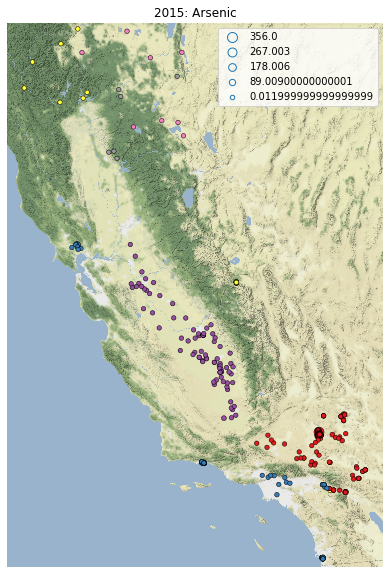

In [81]:
# import geoplot
import geoplot as gplt
import geoplot.crs as gcrs
from cartopy.io.img_tiles import Stamen
import cartopy.crs as ccrs

#plotting the information
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(111, projection=gcrs.Mercator( central_longitude=ca_max_lon-ca_min_lon, 
                                                 min_latitude= ca_min_lat, 
                                                 max_latitude= ca_max_lat) )

# add base layer image
ax1.add_image( Stamen('terrain-background'), 8)

# # Labeling the map
# ax1.text( ca_min_lon, 
#           ca_min_lat+(ca_max_lat-ca_min_lat)/3, 
#          (chem_of_int + ':\n'+ str(year_of_int)),
#           horizontalalignment='left', 
#           verticalalignment='center',
#           fontsize=14,
#           transform=ccrs.Mercator()
#           )
plt.title( (str(year_of_int) + ': '+ chem_of_int) )

# add water quality data points
gplt.pointplot( chem_aqui_ann_subset, 
                projection=gcrs.Mercator(),
                hue='AquiferName', 
                categorical=True,
                legend=True,                
                edgecolor='black', linewidth=0.5,
                scale='NormalizedResultMeasureValue',
                legend_var='scale',
                limits=(1,5),
#                 scale_func=log_scale,
                ax=ax1
                )



## Figure Goal 2. Repeat plot for each year from 2011-2017.



In [82]:
# figID = 230

# for year_of_int in np.arange(2011,2017):
#     # obtain all the samples during the year 2015
#     # year_of_int = 2015
#     annual_cond = ( (mwgd['ActivityStartDate'] > datetime(year_of_int-1,12,31)) &
#                     (mwgd['ActivityStartDate'] < datetime(year_of_int+1, 1, 1)) )
#     annual_subset = mwgd.loc[ annual_cond, : ]

#     # clean list of aquifers
#     # i.e., subset to remove "nan" and "Other Aquifers" listings
#     aquifer_cond = ( ( ~pd.isnull(annual_subset['AquiferName']) ) )# &
#     #                  (annual_subset['AquiferName'] != 'Other aquifers') )
#     aqui_ann_subset = annual_subset.loc[ (aquifer_cond), : ]

#     # obtain all As rows
#     chem_of_int = 'Arsenic'
#     MCL_value = determine_MCL( chem_of_int )
#     chem_cond = aqui_ann_subset['CharacteristicName']  == chem_of_int
#     chem_aqui_ann_subset = aqui_ann_subset.loc[ (chem_cond) ,:]

#     # convert Result measure value
#     chem_aqui_ann_subset['ConvertedResultMeasureValue']  = chem_aqui_ann_subset['ResultMeasureValue']/1e3
#     chem_aqui_ann_subset['NormalizedResultMeasureValue'] = chem_aqui_ann_subset['ConvertedResultMeasureValue']/MCL_value
    
# # =================== subsetting ^^^
# # =================== plotting vvvv

#     #plotting the information
#     fig = plt.figure(figsize=(20,10))
#     figID += 1
#     ax1 = plt.subplot(figID, projection=gcrs.Mercator( central_longitude=ca_max_lon-ca_min_lon, 
#                                                      min_latitude= ca_min_lat, 
#                                                      max_latitude= ca_max_lat) )

#     # add base layer image
#     ax1.add_image( Stamen('terrain-background'), 8)
#     ax1.text( ca_min_lon, 
#               ca_min_lat+(ca_max_lat-ca_min_lat)/3, 
#              (chem_of_int + ':\n'+ str(year_of_int)),
#               horizontalalignment='left', 
#               verticalalignment='center',
#               transform=gcrs.Mercator()
#               )

#     # add water quality data points
#     gplt.pointplot( chem_aqui_ann_subset, 
#                     projection=gcrs.Mercator(),
#                     hue='AquiferName', 
#                     categorical=True,
#                     legend=True,                
#                     edgecolor='black', linewidth=0.5,
#                     scale='NormalizedResultMeasureValue',
#                     legend_var='scale',
#                     limits=(1,5),
#     #                 scale_func=log_scale,
#                     ax=ax1
#                     )

## Remake plot but focused on a specific watershed

Cooccurence of contaminants within a particular aquifer for the year 2015, looking at the co-occurence of As and Nitrate (NO<sub>3</sub><sup>-</sup>). 

Potentially this visualization can be expanded by to compare multiple contaminants. Contaminants are normalized against their MCL.


In [83]:
# output the aquifer names
mwgd['AquiferName'].unique()

array(['Basin and Range basin-fill aquifers', nan,
       'California Coastal Basin aquifers', 'Other aquifers',
       'Pacific Northwest basin-fill aquifers',
       'Central Valley aquifer system',
       'Basin and Range carbonate-rock aquifers',
       'Pacific Northwest volcanic-rock aquifers'], dtype=object)

In [84]:
# obtain all the samples during the year 2015
year_of_int = [2011, 2017] # 2015
annual_cond = ( (mwgd['ActivityStartDate'] > datetime(year_of_int[0]-1,12,31)) &
                (mwgd['ActivityStartDate'] < datetime(year_of_int[1]+1, 1, 1)) )
annual_subset = mwgd.loc[ annual_cond, : ]

# # checking all time...
# annual_subset = mwgd


# select a particular aquifer
aquifer_of_int  = annual_subset['AquiferName'].unique()[5]
aqui_ann_subset = annual_subset.loc[ annual_subset['AquiferName'] == aquifer_of_int, :]

# obtain all As rows
chem_of_int = ['Arsenic', 'Nitrate']
MCLs = [determine_MCL( chem ) for chem in chem_of_int]
chem_cond = ( (aqui_ann_subset['CharacteristicName']  == chem_of_int[0]) | 
              (aqui_ann_subset['CharacteristicName']  == chem_of_int[1]) )
chem_aqui_ann_subset = aqui_ann_subset.loc[ (chem_cond) ,:]

Now we need to esnure that the chemical data is normalized appropriately.

In [85]:
MCLs

[0.01, 45]

In [86]:
chem_aqui_ann_subset['ResultMeasure/MeasureUnitCode'].unique()

array(['mg/l asNO3', 'mg/l as N', 'ug/l', nan], dtype=object)

In [87]:
# remove those row that have 'mg/l as N' as their units
units_cond = chem_aqui_ann_subset['ResultMeasure/MeasureUnitCode'] != 'mg/l as N'
unit_chem_aqui_ann_subset = chem_aqui_ann_subset.loc[ units_cond, :]

In [88]:
unit_chem_aqui_ann_subset.shape

(1137, 56)

In [89]:
# convert Result measure value
# convert the As samples
rows_as  = unit_chem_aqui_ann_subset['CharacteristicName'] == chem_of_int[0]
rows_no3 = unit_chem_aqui_ann_subset['CharacteristicName'] == chem_of_int[1]

In [90]:
# convert As values only, then normalize all values according to their specific MCL
unit_chem_aqui_ann_subset.loc[rows_as, 'ConvertedResultMeasureValue'] = \
        unit_chem_aqui_ann_subset.loc[rows_as, 'ResultMeasureValue']/1e3

unit_chem_aqui_ann_subset.loc[rows_no3, 'ConvertedResultMeasureValue'] = \
        unit_chem_aqui_ann_subset.loc[rows_no3, 'ResultMeasureValue']    

In [91]:
# Now normalizing against the appropriate MCL
unit_chem_aqui_ann_subset.loc[rows_as, 'NormalizedResultMeasureValue'] = \
        unit_chem_aqui_ann_subset.loc[rows_as, 'ConvertedResultMeasureValue']/MCLs[0]

unit_chem_aqui_ann_subset.loc[rows_no3, 'NormalizedResultMeasureValue'] = \
        unit_chem_aqui_ann_subset.loc[rows_no3, 'ConvertedResultMeasureValue']/MCLs[1]

Subdivide the dataset by chemicals to plot and reference separately.

In [99]:
# split by contaminants
as_final_subset  = unit_chem_aqui_ann_subset.loc[ rows_as, :]
no3_final_subset = unit_chem_aqui_ann_subset.loc[ rows_no3, :]

# remove the 'nan' values in the sets
as_final_subset  = as_final_subset.loc[ ~pd.isnull(as_final_subset['NormalizedResultMeasureValue']), : ]
no3_final_subset = no3_final_subset.loc[ ~pd.isnull(no3_final_subset['NormalizedResultMeasureValue']), : ]

Now, we spatially plot the data.

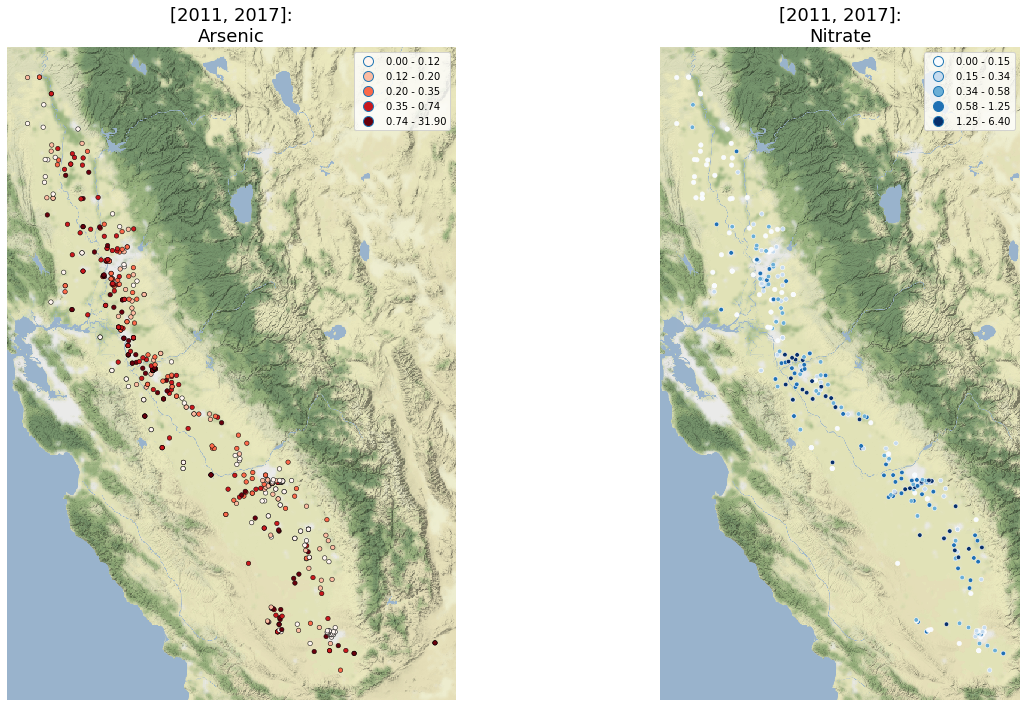

In [106]:
# import geoplot
import geoplot as gplt
import geoplot.crs as gcrs
from cartopy.io.img_tiles import Stamen
import cartopy.crs as ccrs

#plotting the information
fig = plt.figure(figsize=(20,12))
ax1 = plt.subplot(121, projection=gcrs.Mercator( central_longitude=ca_max_lon-ca_min_lon, 
                                                 min_latitude= ca_min_lat, 
                                                 max_latitude= ca_max_lat) )

# add base layer image
ax1.add_image( Stamen('terrain-background'), 8)

# # Labeling the map
# ax1.text( ca_min_lon, 
#           ca_min_lat+(ca_max_lat-ca_min_lat)/3, 
#          (chem_of_int + ':\n'+ str(year_of_int)),
#           horizontalalignment='left', 
#           verticalalignment='center',
#           fontsize=14,
#           transform=ccrs.Mercator()
#           )
plt.title( (str(year_of_int) + ':\n'+
            chem_of_int[0] ), fontsize=18 )

# add water quality data points
gplt.pointplot( as_final_subset, 
                projection=gcrs.Mercator(),
                hue='NormalizedResultMeasureValue', 
#                 categorical=True,
                legend=True,                
                edgecolor='black', linewidth=0.5,
                cmap='Reds',
#                 scale='NormalizedResultMeasureValue',
                legend_var='hue',
#                 limits=(1,5),
#                 scale_func=log_scale,
                ax=ax1
                )

## adding the second subplot
ax1 = plt.subplot(122, projection=gcrs.Mercator( central_longitude=ca_max_lon-ca_min_lon, 
                                                 min_latitude= ca_min_lat, 
                                                 max_latitude= ca_max_lat) )

# adding plot title
plt.title( (str(year_of_int) + ':\n'+
            chem_of_int[1] ), fontsize=18 )
          
# add base layer image
ax1.add_image( Stamen('terrain-background'), 8)
gplt.pointplot( no3_final_subset,
                projection=gcrs.Mercator(),
                hue='NormalizedResultMeasureValue', 
#                 categorical=True,
                legend=True,                
                edgecolor='white', linewidth=0.5,
                cmap='Blues',
#                  scale='NormalizedResultMeasureValue',
                legend_var='hue',
#                  limits=(1,5),
#                 scale_func=log_scale,
                ax=ax1
                )

plt.savefig('CA_drought_CentralValleyAq_As_NO3.png', bbox_inches='tight')


In [ ]:
np.arange(2010,2018) # <-- should only need 2010-2015 based on for loop/time counting

In [ ]:
chem_aqui_ann_subset['ResultMeasureValue'].max()

In [ ]:
plt.plot(chem_aqui_ann_subset['NormalizedResultMeasureValue'])
plt.show()

In [ ]:
chem_aqui_ann_subset.head()

In [ ]:
type(chem_aqui_ann_subset.loc['USGS-323932117050801','ResultMeasure/MeasureUnitCode'])

In [ ]:
mwgd['CharacteristicName'].unique()